# Time series MODEL

In [1]:
import pandas as pd
import sqlite3
from data_collections.constants import SQLITE_DATABASE_MODEL

In [2]:
TABLE_NAME = "course_info" 

In [3]:
connection = sqlite3.connect(SQLITE_DATABASE_MODEL)
c = connection.cursor()

In [4]:
obs_data = pd.read_sql_query(f'SELECT * FROM {TABLE_NAME}', connection)

In [5]:
data = obs_data.copy()

In [6]:
data.head()

,faculty_code,faculty,course_code,course_name,class,teacher,year,day,start_time,end_time,student_nums
0,GÖRSEL İLETİŞİM TASARIMI_GSF102,GÖRSEL İLETİŞİM TASARIMI,GSF102,TEMEL TASARIM II,L-102(GİT ATÖLYE II)[60],SEÇİL KARTOPU,1,Pazartesi,09:00,14:50,41
1,GÖRSEL İLETİŞİM TASARIMI_GSF106,GÖRSEL İLETİŞİM TASARIMI,GSF106,ÇİZİM II,L-101(GİT ATÖLYE I)[60],Öğr.Gör. İSMAİL FURKAN YAVUZ,1,Pazartesi,09:00,14:50,44
2,GÖRSEL İLETİŞİM TASARIMI_BLG102,GÖRSEL İLETİŞİM TASARIMI,BLG102,BİLGİ TEKNOLOJİLERİ KULLANIMI,AZ 13(BİLGİSAYAR LAB.)[80],Öğr.Gör. AHMET AKSOY,1,Salı,09:00,15:50,44
3,İKTİSAT_ENG104,İKTİSAT,ENG104,ACADEMIC ENGLISH II,B382(KONFERANS SALONU)[143],Öğr.Gör. MÜGE AKGEDİK AKOĞLANOĞLU,1,Pazartesi,09:00,16:50,35
4,İKTİSAT_ECON102,İKTİSAT,ECON102,INTRODUCTION TO ECONOMICS II,B338-D1(DERSLİK1)[121],KORAY GÖKSAL,1,Pazartesi,14:00,16:50,91


In [7]:
print(f'there are {len(data.columns)} columns and {len(data)} rows')

there are 11 columns and 623 rows


Yes — **you absolutely should keep the `day` feature** when using the second option (the simpler model without class info). Great catch! 👏

---

### ✅ Why Include `day` in the Aggregated Model?

Even if you drop detailed class info like `course_code` and `teacher`, the **day of the week** (e.g., Monday, Tuesday) can still impact student flow. For example:

- **Mondays** might have heavier morning traffic.
- **Fridays** might see early departures.
- **Midweek** might have more evenly distributed classes.

So the same `end_time` (say 10:00 AM) could have **very different bus stop densities** depending on the day.

---

### 🧠 How to Include `day` in Your Dataset?

In your **aggregated dataset**, add a column for the day (as text or number).

#### 🧾 Example Aggregated Dataset:

| day       | end_time | total_students | bus_stop_count | density_level |
|-----------|----------|----------------|----------------|---------------|
| Monday    | 10:00    | 265            | 53             | Medium        |
| Monday    | 10:10    | 265            | 133            | High          |
| Tuesday   | 10:00    | 190            | 40             | Low           |
| Friday    | 10:00    | 300            | 160            | High          |

Then, **encode `day`** for the ML model:
- Label encode (`Monday` → 0, `Tuesday` → 1, ...)  
- Or one-hot encode (`is_Monday`, `is_Tuesday`, ...)

---

### ✅ Final Tip:
Also consider adding **week numbers or exam weeks** in the future, if patterns change seasonally.

Let me know if you want help **adding the `day` feature into the pipeline** or automating it in code.

### STEP 1: structure the data for the model

In [8]:
# list all the columns to drop

print(data.columns)

Index(['faculty_code', 'faculty', 'course_code', 'course_name', 'class',
       'teacher', 'year', 'day', 'start_time', 'end_time', 'student_nums'],
      dtype='object')


In [9]:
to_drop = ['faculty_code', 'faculty', 'course_name', 'class', 'year', 'start_time']

In [10]:
data.drop(labels=to_drop,axis=1, inplace=True)

In [11]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [12]:
import pandas as pd
from datetime import datetime, timedelta

def calculate_bus_stop_counts(df):
    """
    Takes a class schedule DataFrame and returns a new DataFrame with time slots and bus_stop_count.
    Works using minutes-from-midnight as time representation.
    
    Required columns in df:
    - 'day' (e.g., Monday)
    - 'end_time' (string in 'HH:MM' format)
    - 'student_nums' (integer)
    """
    
    # Convert end_time to datetime for parsing, then extract minutes-from-midnight
    df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M')
    df['end_time_minutes'] = df['end_time'].dt.hour * 60 + df['end_time'].dt.minute
    
    time_slots = []

    for _, row in df.iterrows():
        end_time_min = row['end_time_minutes']
        student_count = row['student_nums']
        day = row['day']
        
        # Define departure distribution
        departures = [
            (0, 0.20),  # 0-5 minutes
            (5, 0.50),  # 5-10 minutes
            (10, 0.30)  # 10-15 minutes
        ]

        for offset, fraction in departures:
            slot_min = end_time_min + offset  # Still in minutes-from-midnight
            time_slots.append({
                'day': day,
                'time_slot_minutes': slot_min,
                'bus_stop_count': int(student_count * fraction)
            })

    # Create DataFrame from list of time slots
    result_df = pd.DataFrame(time_slots)

    # Group by day and time slot to sum overlapping students
    result_df = result_df.groupby(['day', 'time_slot_minutes'], as_index=False).sum()
    #result_df['time_slot'] = result_df['time_slot_minutes'].apply(lambda x: f"{x // 60:02}:{x % 60:02}")


    return result_df


In [13]:
data = calculate_bus_stop_counts(data)
print(data)

          day  time_slot_minutes  bus_stop_count
0        Cuma                650              30
1        Cuma                655              78
2        Cuma                660              46
3        Cuma                710              91
4        Cuma                715             232
..        ...                ...             ...
158  Çarşamba               1075              63
159  Çarşamba               1080              37
160  Çarşamba               1130              36
161  Çarşamba               1135              91
162  Çarşamba               1140              54

[163 rows x 3 columns]


In [14]:
def density_estimation(df):

    # low -> 40 AND BELOW
    # MEDIUM -> 41 - 80
    # HIGH -> 81+

    density = ['LOW', 'MEDIUM', 'HIGH']
    student_density = []

    for _, row in df.iterrows():

        if row['bus_stop_count'] <= 40:
            student_density.append(density[0]) 
        elif row['bus_stop_count'] > 40 and row['bus_stop_count'] <= 80:
            student_density.append(density[1]) 
        elif row['bus_stop_count'] > 80:
            student_density.append(density[2])

    df['density'] = student_density 
    return df

In [15]:
data = density_estimation(data)

In [16]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,LOW
1,Cuma,655,78,MEDIUM
2,Cuma,660,46,MEDIUM
3,Cuma,710,91,HIGH
4,Cuma,715,232,HIGH
...,...,...,...,...
158,Çarşamba,1075,63,MEDIUM
159,Çarşamba,1080,37,LOW
160,Çarşamba,1130,36,LOW
161,Çarşamba,1135,91,HIGH


next encoding

In [17]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [18]:
density_col = data['density']

In [19]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [20]:
print(density_col)

0         LOW
1      MEDIUM
2      MEDIUM
3        HIGH
4        HIGH
        ...  
158    MEDIUM
159       LOW
160       LOW
161      HIGH
162    MEDIUM
Name: density, Length: 163, dtype: object


In [21]:
le = LabelEncoder()

In [22]:
d_ = le.fit_transform(density_col)

In [23]:
data['density'] = d_

In [24]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,1
1,Cuma,655,78,2
2,Cuma,660,46,2
3,Cuma,710,91,0
4,Cuma,715,232,0
...,...,...,...,...
158,Çarşamba,1075,63,2
159,Çarşamba,1080,37,1
160,Çarşamba,1130,36,1
161,Çarşamba,1135,91,0


In [25]:
oh = OneHotEncoder()

# one hot encoding for the days column
## we commented it out because the randomforestclassifier does not need one hot encoding

In [26]:
"""
days = pd.get_dummies(data['day'], prefix='day')
new_drop = ['day']
data.drop(labels=new_drop, axis=1, inplace=True)
_d = days.apply(le.fit_transform)
data = data.join(_d)
"""

"\ndays = pd.get_dummies(data['day'], prefix='day')\nnew_drop = ['day']\ndata.drop(labels=new_drop, axis=1, inplace=True)\n_d = days.apply(le.fit_transform)\ndata = data.join(_d)\n"

In [27]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,1
1,Cuma,655,78,2
2,Cuma,660,46,2
3,Cuma,710,91,0
4,Cuma,715,232,0
...,...,...,...,...
158,Çarşamba,1075,63,2
159,Çarşamba,1080,37,1
160,Çarşamba,1130,36,1
161,Çarşamba,1135,91,0


In [28]:
#data['day_encoded'] = le.fit_transform(data['day'])

In [29]:
#data = data.drop(columns=['day'])


In [30]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,1
1,Cuma,655,78,2
2,Cuma,660,46,2
3,Cuma,710,91,0
4,Cuma,715,232,0
...,...,...,...,...
158,Çarşamba,1075,63,2
159,Çarşamba,1080,37,1
160,Çarşamba,1130,36,1
161,Çarşamba,1135,91,0


In [31]:
data.drop('density', axis=1)

,day,time_slot_minutes,bus_stop_count
0,Cuma,650,30
1,Cuma,655,78
2,Cuma,660,46
3,Cuma,710,91
4,Cuma,715,232
...,...,...,...
158,Çarşamba,1075,63
159,Çarşamba,1080,37
160,Çarşamba,1130,36
161,Çarşamba,1135,91


## model

In [32]:
import pandas as pd

# Sample setup if not done already
# data = pd.read_csv('your_data.csv') 

# Map Turkish days to weekday offsets
day_to_offset = {
    'Pazartesi': 0,
    'Salı': 1,
    'Çarşamba': 2,
    'Perşembe': 3,
    'Cuma': 4,
    'Cumartesi': 5,
    'Pazar': 6
}

# Map days to numeric offsets
data['day_offset'] = data['day'].map(day_to_offset)

# Debug tip: check for NaNs
if data['day_offset'].isna().any():
    print("⛔ Unmapped values:")
    print(data[data['day_offset'].isna()])

# Construct datetime
base_date = pd.Timestamp("2025-04-07")  # Monday
data['ds'] = data.apply(
    lambda row: base_date + pd.to_timedelta(row['day_offset'], unit='D') +
                pd.to_timedelta(row['time_slot_minutes'], unit='m'),
    axis=1
)

# Rename target to 'y'
data['y'] = data['bus_stop_count']

# Final Prophet-ready format
prophet_data = data[['ds', 'y']]


In [33]:
prophet_data

,ds,y
0,2025-04-11 10:50:00,30
1,2025-04-11 10:55:00,78
2,2025-04-11 11:00:00,46
3,2025-04-11 11:50:00,91
4,2025-04-11 11:55:00,232
...,...,...
158,2025-04-09 17:55:00,63
159,2025-04-09 18:00:00,37
160,2025-04-09 18:50:00,36
161,2025-04-09 18:55:00,91


In [34]:
from prophet import Prophet

In [35]:
model = Prophet()
model.fit(prophet_data)

10:33:58 - cmdstanpy - INFO - Chain [1] start processing
10:33:59 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future = model.make_future_dataframe(periods= 36, freq='5min')
forecast = model.predict(future)

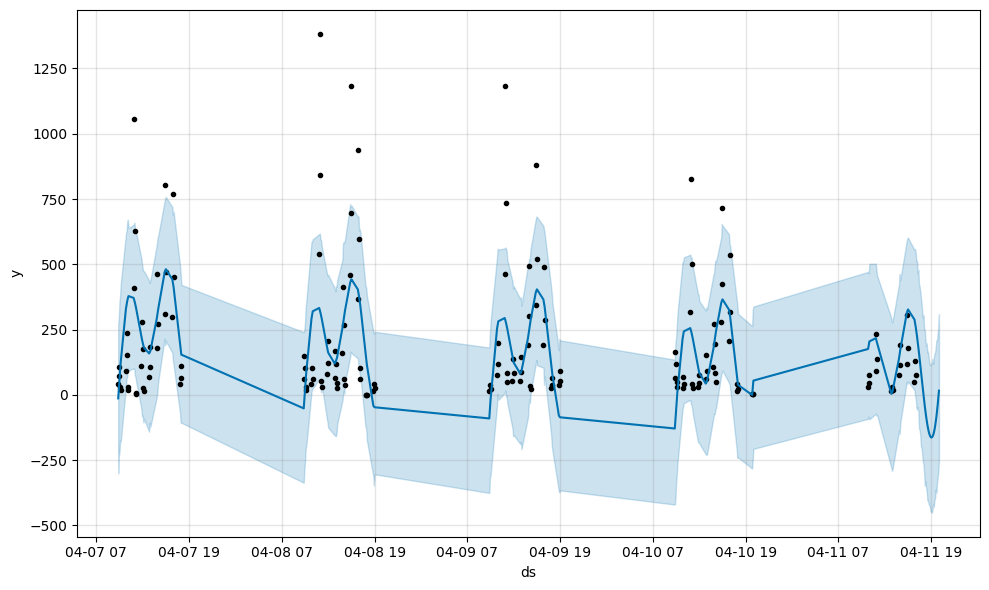

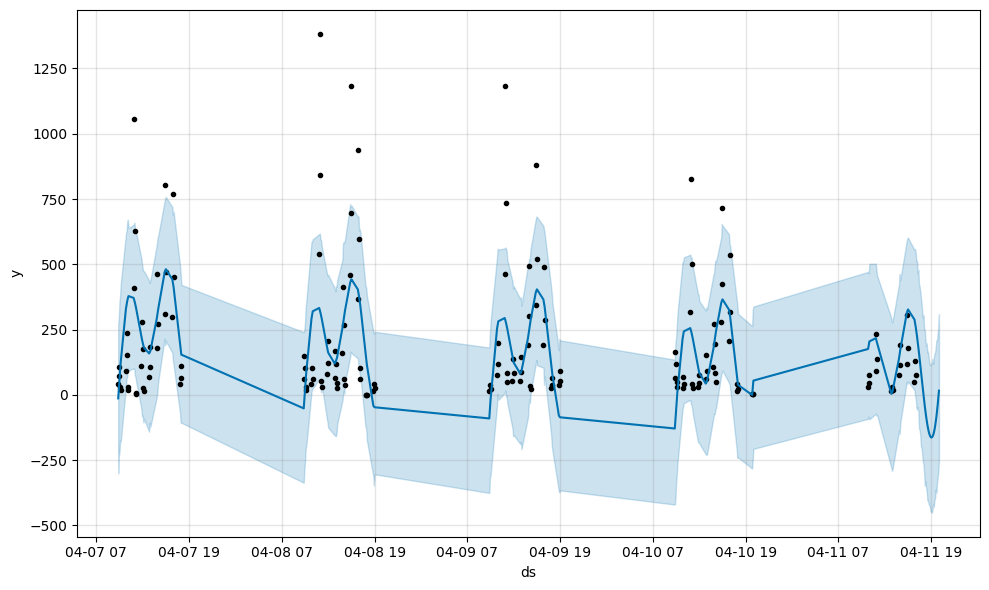

In [37]:
model.plot(forecast)

10:34:00 - cmdstanpy - INFO - Chain [1] start processing
10:34:00 - cmdstanpy - INFO - Chain [1] done processing


Test Set MAE: 133.22
Test Set RMSE: 161.54


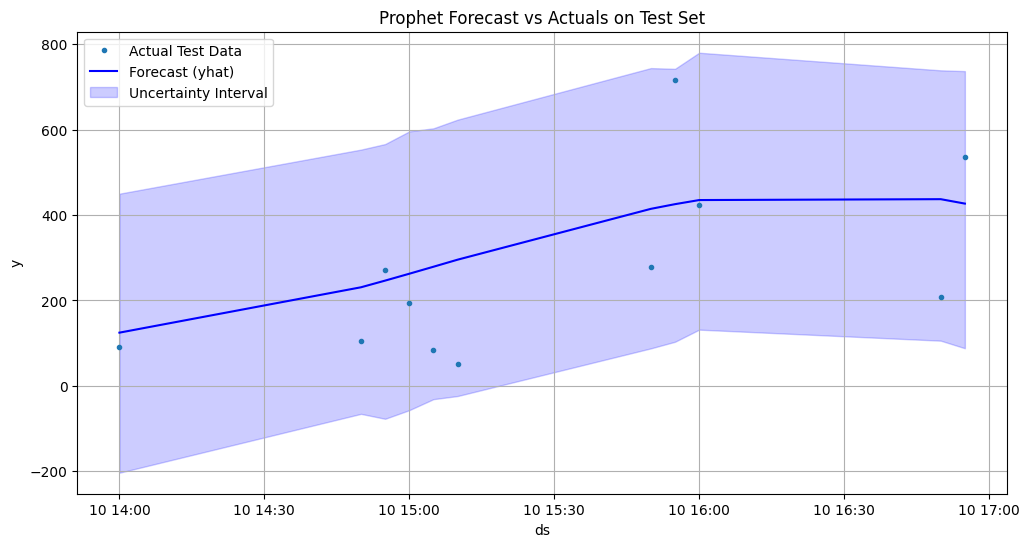

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

prophet_data = prophet_data.sort_values('ds')

split_index = len(prophet_data) - 36

train_data = prophet_data.iloc[:split_index]
test_data = prophet_data.iloc[split_index:]

model = Prophet()
model.fit(train_data)


future = model.make_future_dataframe(periods=len(test_data), freq='5min')

forecast = model.predict(future)


forecast_test_period = forecast[forecast['ds'].isin(test_data['ds'])]

results_df = pd.merge(test_data[['ds', 'y']], forecast_test_period[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

mae = mean_absolute_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mean_squared_error(results_df['y'], results_df['yhat']))

print(f"Test Set MAE: {mae:.2f}")
print(f"Test Set RMSE: {rmse:.2f}")

# 6. Visualize the Forecast vs Actuals on the Test Set
plt.figure(figsize=(12, 6))
plt.plot(results_df['ds'], results_df['y'], label='Actual Test Data', marker='.', linestyle='None')
plt.plot(results_df['ds'], results_df['yhat'], label='Forecast (yhat)', color='blue')
plt.fill_between(results_df['ds'], results_df['yhat_lower'], results_df['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title('Prophet Forecast vs Actuals on Test Set')
plt.xlabel('ds')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


Okay, let's interpret these test set results based on the plot and the metrics (MAE: 136.78, RMSE: 164.93).

Interpretation:

General Trend Capture: The blue forecast line (yhat) seems to capture the general upward trend present in the actual test data points during this 3-hour window (14:00 to 17:00). It recognizes that the values are generally increasing.

Accuracy of Point Forecasts:

The actual data points (blue dots) are quite scattered around the forecast line. Some points are close, but several are significantly far away.

The MAE of 136.78 confirms this visual observation. On average, the model's prediction was off by about 137 units. Whether this is "good" or "bad" depends heavily on the scale and required precision for your application, but looking at your y-axis (ranging visually from roughly 0 to 700 in this plot), an average error of 137 seems quite substantial.

The RMSE of 164.93 is higher than the MAE. This is expected, as RMSE penalizes larger errors more heavily. The difference between RMSE and MAE suggests that there are some specific predictions that were particularly inaccurate (likely the points furthest from the blue line, such as the highest point near 16:00 and the one just before 17:00), contributing disproportionately to the overall error.

Volatility/Specificity: The model produces a relatively smooth forecast line. The actual data, however, shows more short-term volatility or noise. The model isn't capturing these finer-grained fluctuations or sharp peaks well.

Uncertainty Interval:

The light blue shaded area represents the model's uncertainty. Encouragingly, most of the actual data points fall within this uncertainty band. This suggests the model has a reasonable (though perhaps not perfect) estimate of its own prediction uncertainty for most of the period.

However, the highest point around 16:00 appears to be right on the edge or potentially slightly outside the upper bound. This indicates that the model might be underestimating the possibility of these higher peaks occurring.

As expected, the uncertainty interval widens over time, reflecting increased uncertainty further into the future.

Overall Conclusion:

The Prophet model, trained on the preceding data, was able to identify the general upward direction during the test period.

However, its specific point predictions lack precision, leading to relatively high MAE and RMSE values compared to the scale of the data.

The model smooths out the actual volatility and struggles to predict the exact timing and magnitude of peaks/dips within this short timeframe.

The uncertainty intervals are mostly adequate but might be slightly too narrow to consistently capture the most extreme values observed in the test set.

Possible Next Steps:

Feature Engineering: Are there external factors (regressors) that influence y that could be added to the model?

Parameter Tuning: Experiment with Prophet's parameters (changepoint_prior_scale, seasonality_prior_scale, seasonality_mode) to see if you can get a better fit or make it react more strongly to recent changes.

Check Data: Re-examine the training data for anomalies or patterns that might explain the model's behavior. Ensure the 5-minute frequency is appropriate.

Longer Test Set: Evaluate over a longer period to see if performance varies across different times or days.

In [40]:
a = pd.DataFrame()
time = ['2025-04-16 16:00:00']
a['ds'] = time
r = model.predict(a)

In [41]:
r

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-04-16 16:00:00,36.860285,70.748068,709.346778,36.860285,36.860285,357.017622,357.017622,357.017622,357.017622,357.017622,357.017622,0.0,0.0,0.0,393.877907
